In [331]:
#-----------------------------------------------------------------------------#
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
# dummy data using OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Load training data and transform to analyzable format
df = pd.read_csv('train.csv', index_col=['Id']) 

for col in df.columns:
    if df[col].dtypes == 'object':
        df[col]=df[col].fillna('0') #fill na with 0
    else:
        df[col]=df[col].fillna(0)
        
for col in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
    df[col] = df['YrSold'] - df[col]
#change SalePrice to fold of 1k
df['SalePrice'] = df.SalePrice / 1000
df.shape   

(1460, 80)

In [383]:
# Q1: Bedroom number and or living area, which matters more?
# Solution-1: Plot the ralationship of SalePrice with Living Area with BedRoom information

def plot_bedroom(df,xlim,ylim):
    fig = plt.figure(figsize=(10,7))
    colors = dict(zip(df.BedroomAbvGr.unique(),np.array(['C'+str(s) for s in range(len(df.BedroomAbvGr.unique()))])))
    plt.scatter(df.GrLivArea, df.SalePrice,
                s=df.BedroomAbvGr*30,
                c=df.BedroomAbvGr.replace(colors),alpha=0.5)

    for i in range(len(df.BedroomAbvGr.unique())):
        plt.scatter(0.01,0.01,
                    c='C'+str(i),alpha=0.5,
                    label=df.BedroomAbvGr.unique()[i])
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(title='Bedroom No.')
    plt.xlabel('GrLivArea')
    plt.ylabel('SalePrice (k)')
    plt.show()

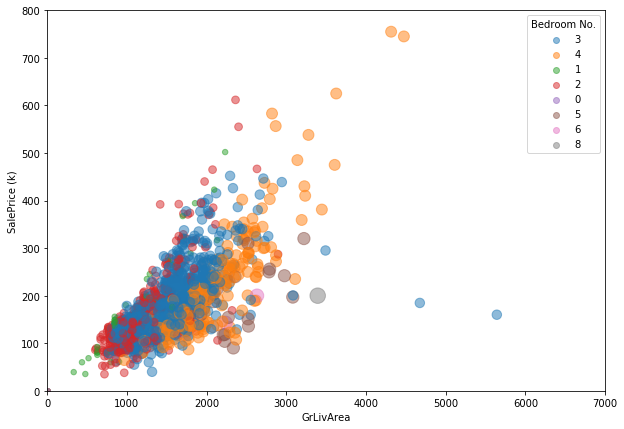

In [384]:
plot_bedroom(df,xlim=[0,7000],ylim=[0,800])

In [402]:
def plot_mean_sd_BR(df):
    mean = df.groupby('BedroomAbvGr').SalePrice.mean()
    sd = df0.groupby('BedroomAbvGr').SalePrice.std()
    mean.plot(kind='bar',yerr=sd)

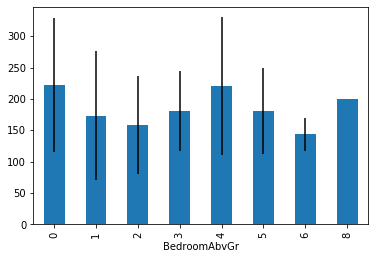

In [403]:
plot_mean_sd_BR(df)

(1229, 80)

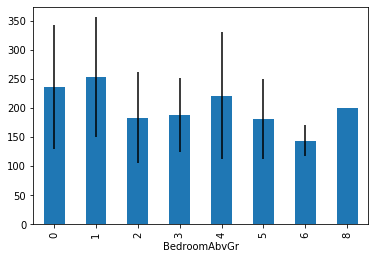

In [407]:
df1000 = df[df.GrLivArea > 1000]
plot_mean_sd_BR(df1000)
df1000.shape

(675, 80)

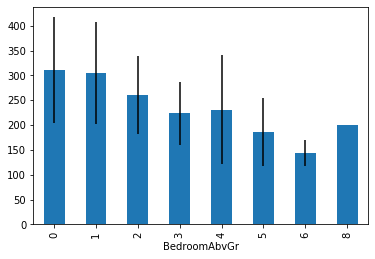

In [408]:
df1500 = df[df.GrLivArea > 1500]
plot_mean_sd_BR(df1500)
df1500.shape

In [410]:
# choose the model according to random2_search_mse in First model
import xgboost as xgb
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15000000000000002,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
             n_estimators=150, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.6500000000000001, verbosity=1)

In [411]:
df_train = df1500
y_train = df_train.SalePrice
X_train = df_train.drop('SalePrice',axis=1)

le = LabelEncoder()
X_train = X_train.apply(lambda x: le.fit_transform(x))
categorical_mask = (X_train.dtypes == 'object')
ohe = OneHotEncoder(categorical_features=categorical_mask, sparse=False)
X_train = ohe.fit_transform(X_train)

model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15000000000000002,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
             n_estimators=150, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.6500000000000001, verbosity=1)

In [414]:
y_predict = model.predict(X_train)


In [415]:
from sklearn.metrics import r2_score
r2_score(y_train,y_predict)

0.9999870820997248

In [421]:
df_predict = df1500
df_predict.SalePrice = y_predict


In [422]:
# simulation with everything is the same but only change bedroom numbers randomly.

def simulate_bedroom(df_s):
    n = df_s.shape[0]
    loc = np.random.randint(0,n)
    data = df_s.iloc[loc] # choose a random number to assign all the other attributes
    print(loc, data.GrLivArea)
    
    for col in df_s.columns:
        if col == 'BedroomAbvGr':
            df_s[col] = [np.random.randint(1,6) for i in range(n)] # randomize bedroom numbers
        elif col == 'GrLivArea':
            pass
        else:
            df_s[col] = [data[col] for i in range(n)]
    
    return df_s

In [423]:
def simulation_price(model,df_new):
    X = df_new
    X = X.apply(lambda x: le.fit_transform(x))
    X = ohe.fit_transform(X)

    df_new['SalePrice'] = model.predict(X)
    
    return df_new

50 2201


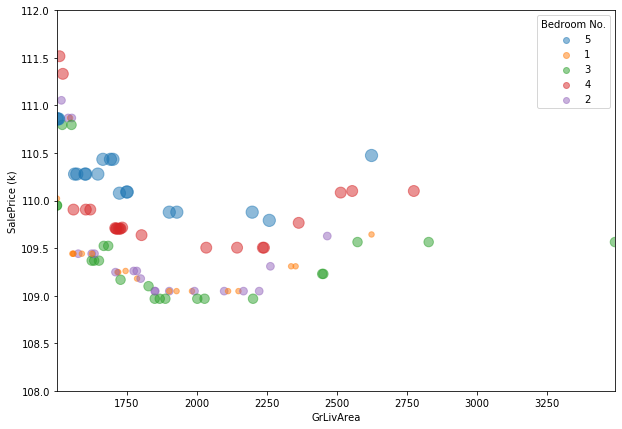

87 1844


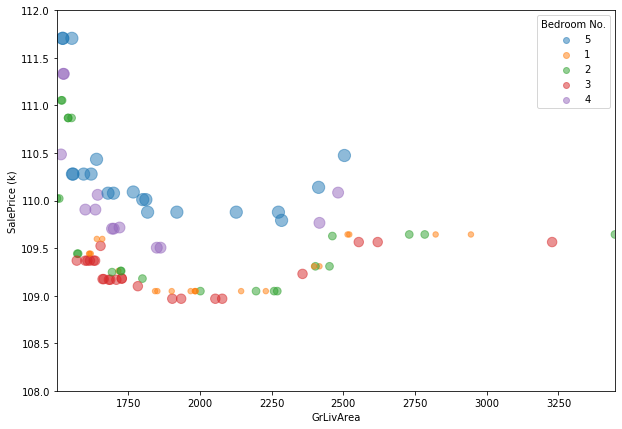

59 2157


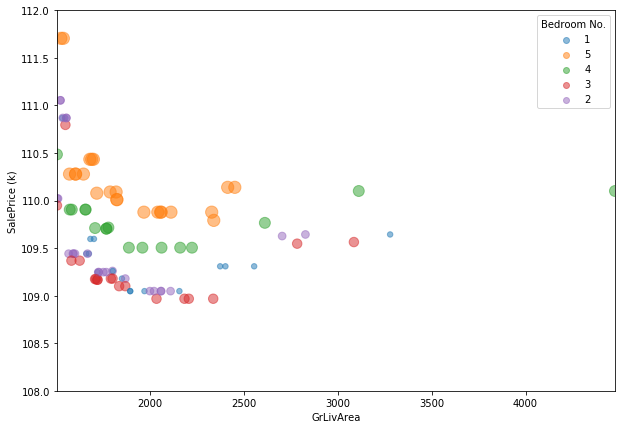

43 1689


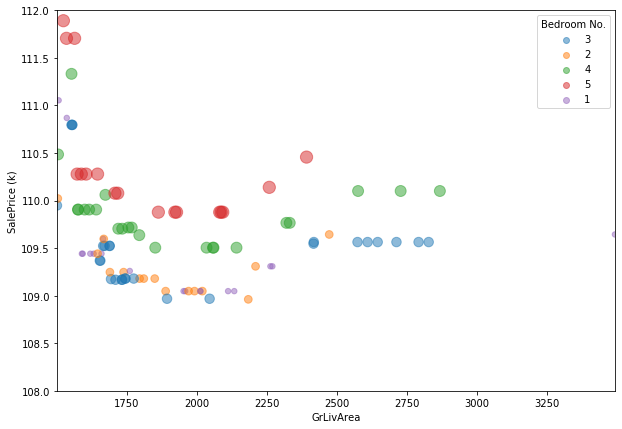

64 3112


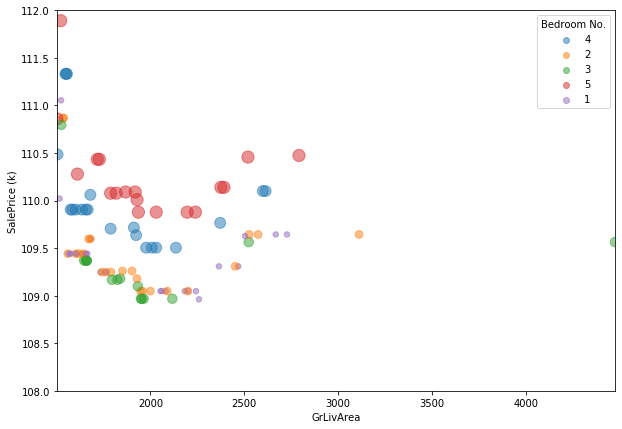

CPU times: user 2.01 s, sys: 67.2 ms, total: 2.08 s
Wall time: 2.22 s


In [425]:
%%time
df1 = df_predict.drop('SalePrice',axis=1)

for i in range(5):
    
    df_s = df1.sample(n=100,replace=True)
    df_new = simulate_bedroom(df_s)

    y = simulation_price(model,df_new)
    plot_bedroom(df_new,
                 [math.floor(df_new.GrLivArea.min()),math.ceil(df_new.GrLivArea.max())],
                 [math.floor(df_new.SalePrice.min()),math.ceil(df_new.SalePrice.max())])


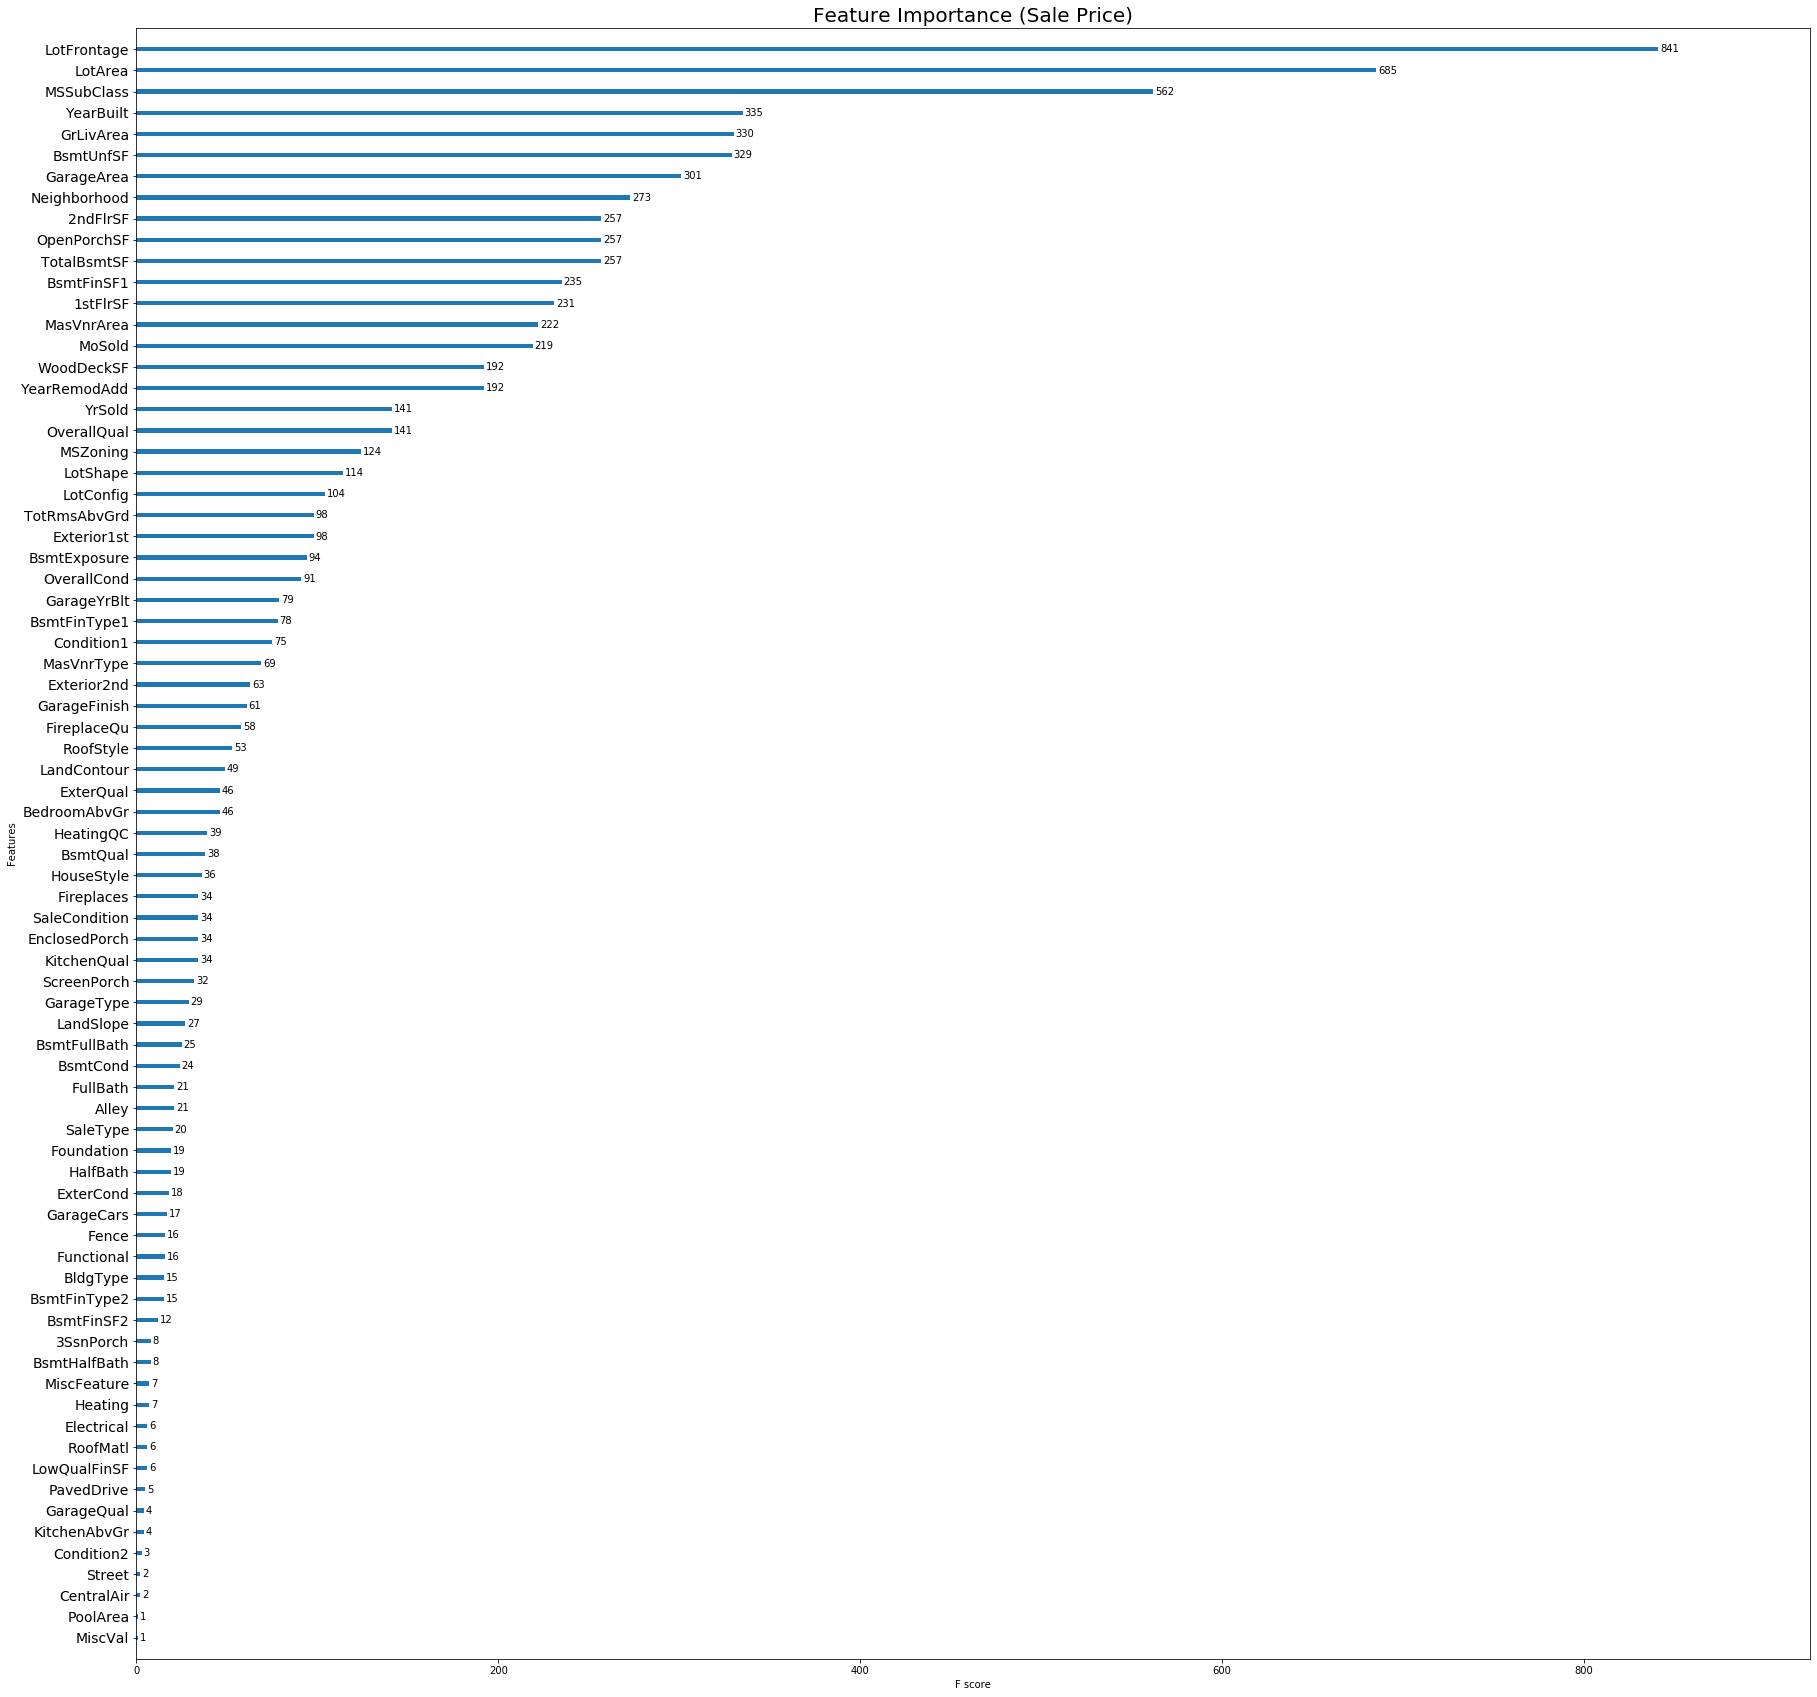

In [429]:
fig1, ax1 = plt.subplots(1,1,figsize=(30,30))
from xgboost import plot_importance
g = plot_importance(model,ax=ax1,grid=False)

oldy = g.yaxis.get_majorticklabels()

features = ['f'+str(x) for x in range(len(df1.columns))]
feature_dict = dict(zip(features,df1.columns))

newy = [str(feature_dict[y._text]) for y in oldy]
g.set_yticklabels(newy, rotation=0, fontsize = 14)

plt.title('Feature Importance (Sale Price)',fontsize=20)

plt.show()

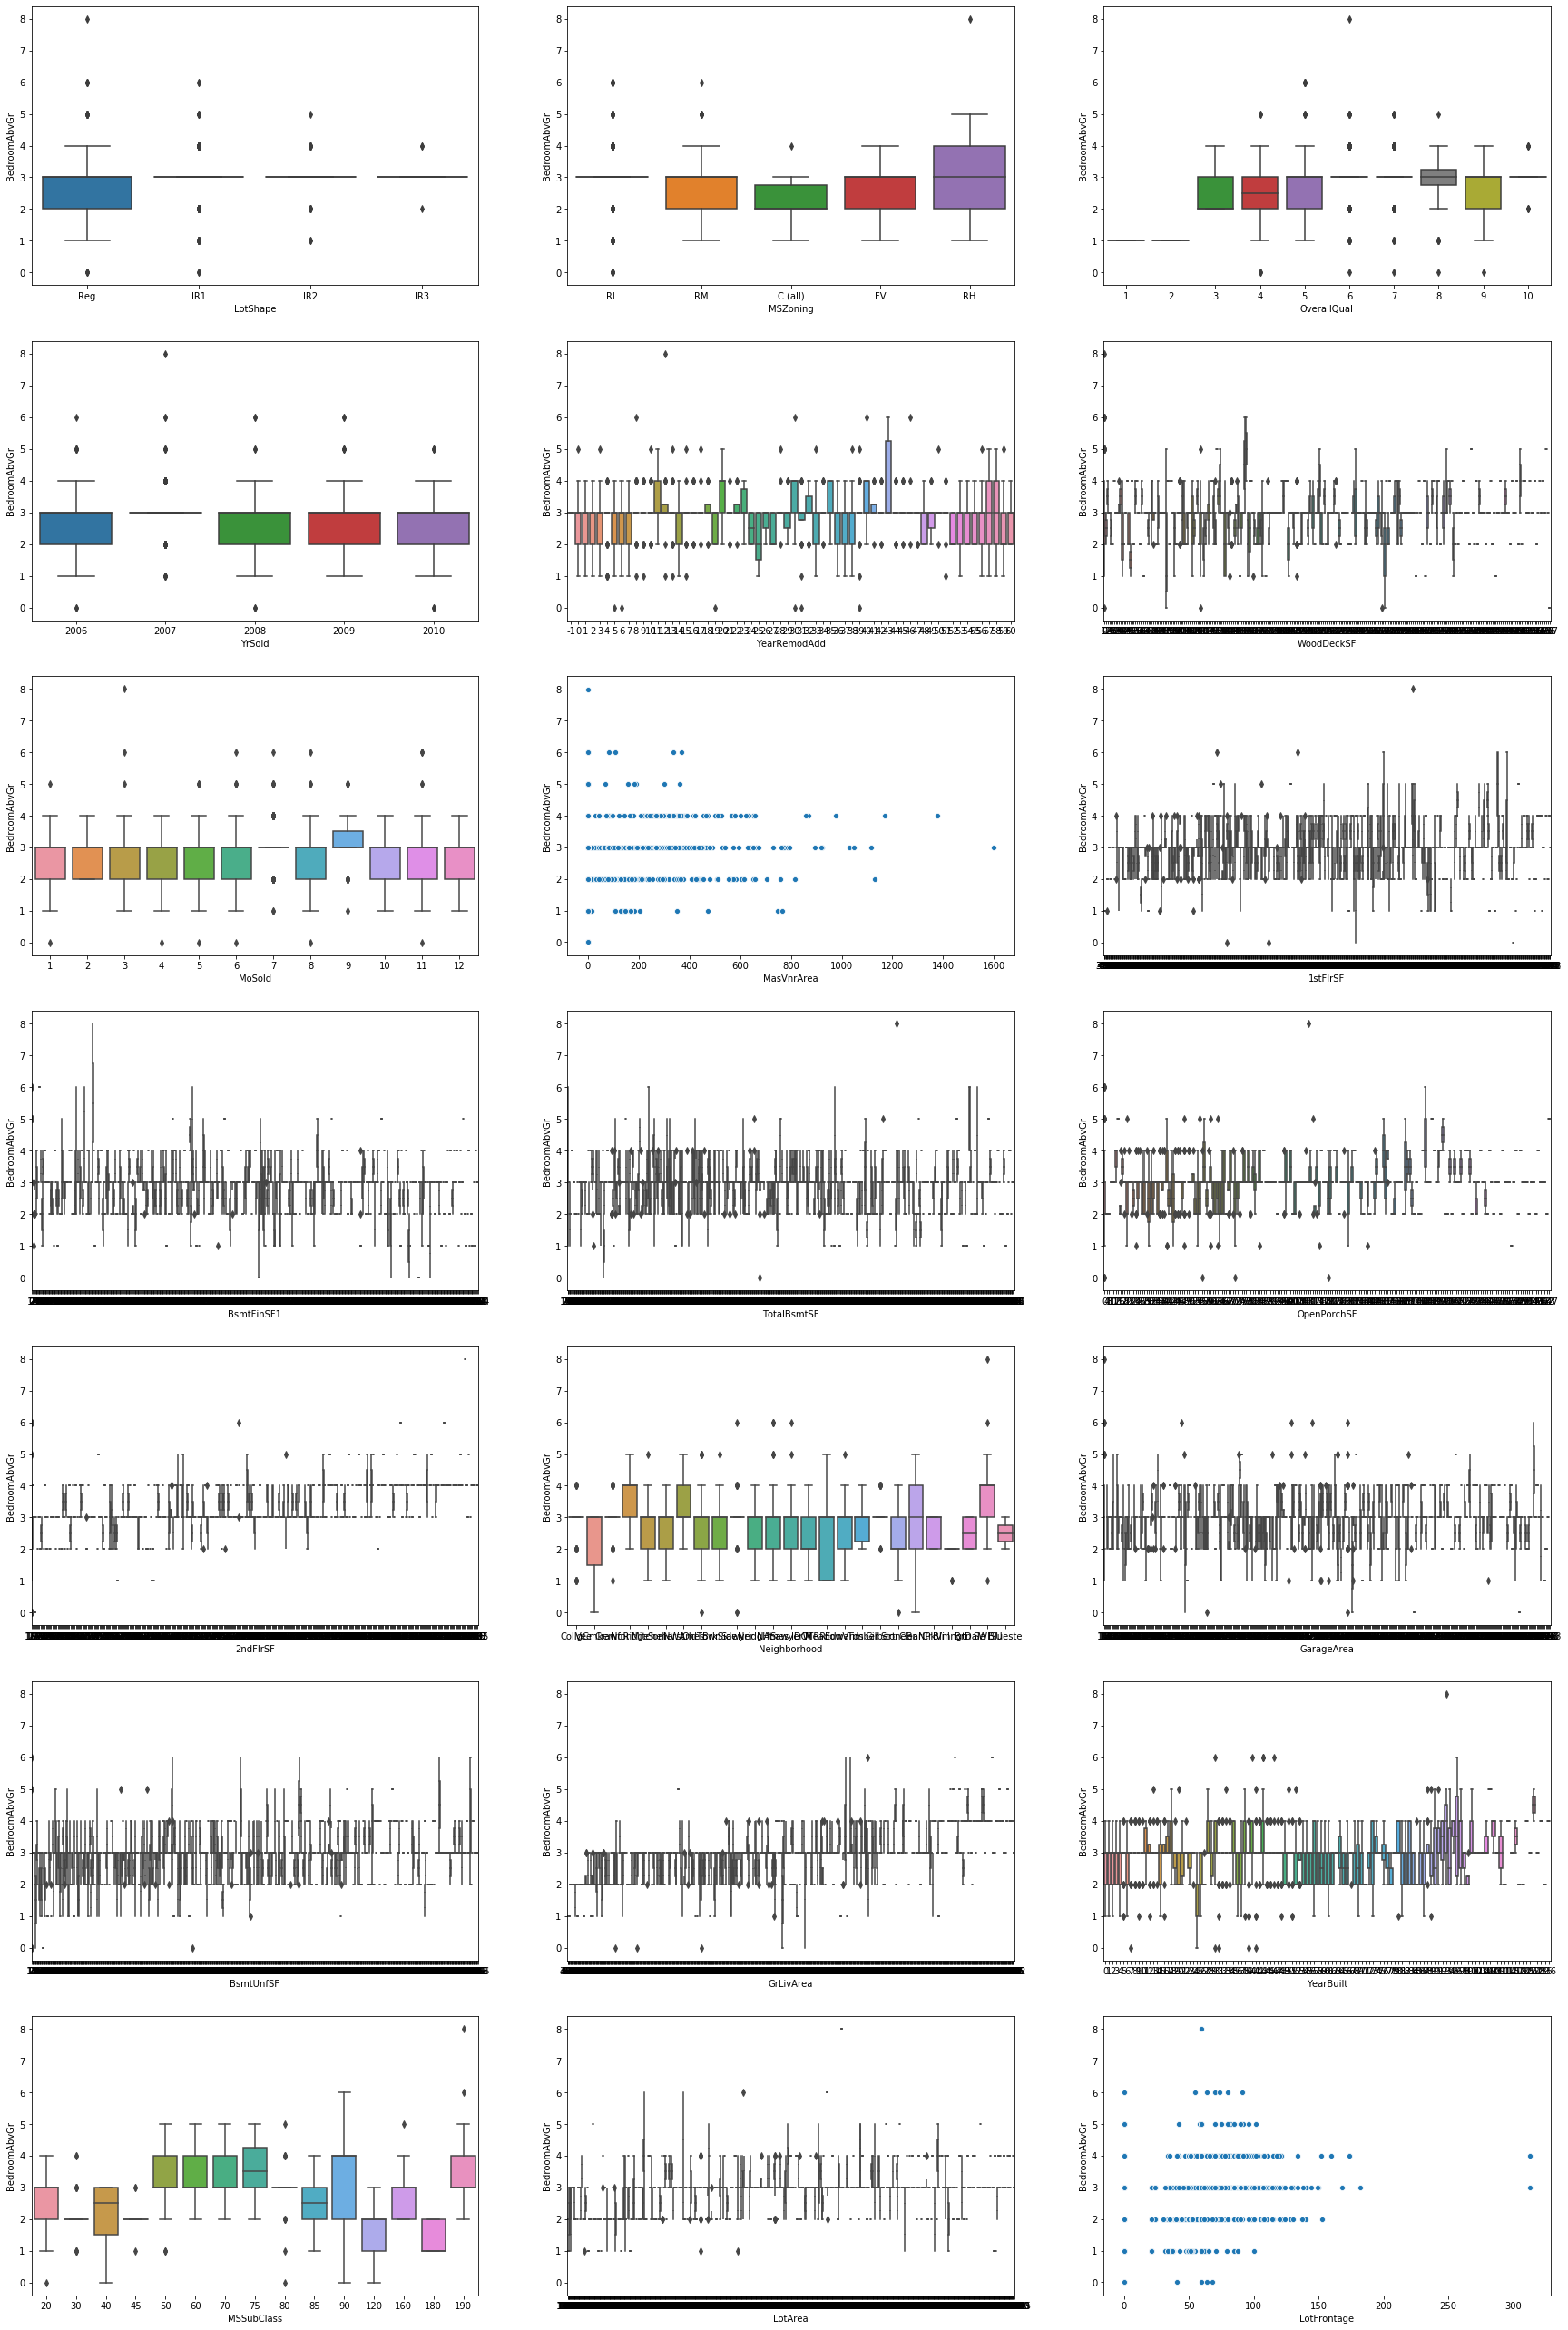

In [434]:
import seaborn as sns
fig = plt.figure(figsize=(30,60))
y_col = 'BedroomAbvGr'
a = 0 #active plot number
for col in newy[55:]:
    a += 1
    ax = fig.add_subplot(9,3,a)
    if df[col].dtype == 'float64':
        sns.scatterplot(x=col, y=y_col, data=df,ax=ax)
    else:
        sns.catplot(x=col, y=y_col,kind='box',data=df,ax=ax)

    ax.set_xlabel(col)
    plt.close(2)

In [452]:
def simulate_m_n(df_s,icol):
    n = df_s.shape[0]
    loc = np.random.randint(0,n)
    data = df_s.iloc[loc] # choose a random number to assign all the other attributes
    print(loc, data.GrLivArea)
    
    for col in df_s.columns:
        if col == 'BedroomAbvGr':
            df_s[col] = [np.random.randint(1,6) for i in range(n)] # randomize bedroom numbers
        elif col == icol:
            df_s[col] = [(df[col].max() - np.random.randint(1,6)*int((df[col].max()-df[col].min())/6)) for i in range(n)]
        elif col == 'GrLivArea':
            pass
        else:
            df_s[col] = [data[col] for i in range(n)]
    
    return df_s

In [449]:
def simulate_m(df_s,icol):
    n = df_s.shape[0]
    loc = np.random.randint(0,n)
    data = df_s.iloc[loc] # choose a random number to assign all the other attributes
    print(loc, data.GrLivArea)
    
    for col in df_s.columns:
        if col == 'BedroomAbvGr':
            df_s[col] = [np.random.randint(1,6) for i in range(n)] # randomize bedroom numbers
        elif col == icol:
            df_s[col] = [np.random.randint(1,6)*int((df[col].max()-df[col].min())/6) for i in range(n)]
        elif col == 'GrLivArea':
            pass
        else:
            df_s[col] = [data[col] for i in range(n)]
    
    return df_s

71 2344
MasVnrArea


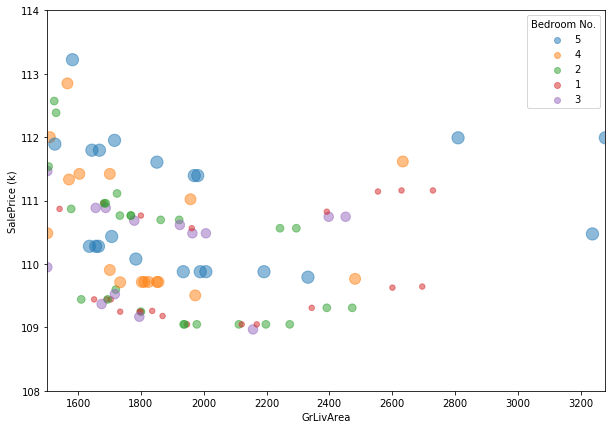

20 4316
BsmtFinSF1


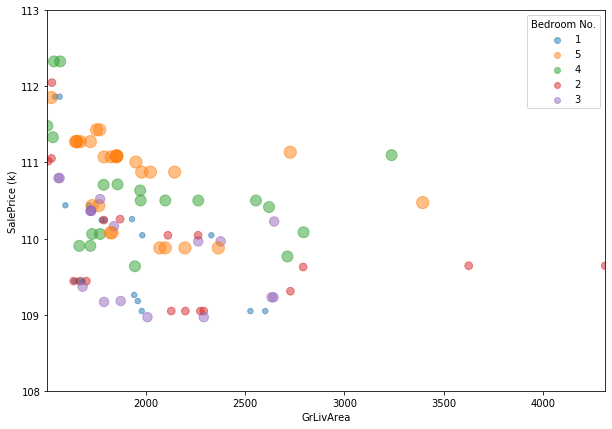

15 1803
MSSubClass


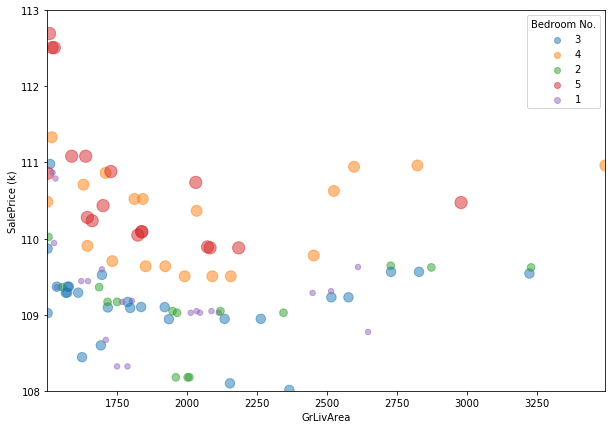

84 2126
LotFrontage


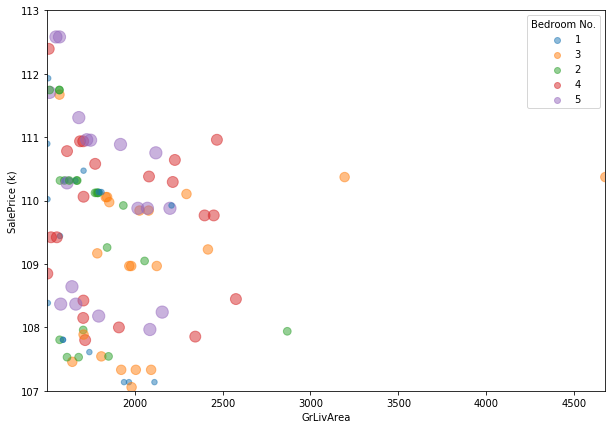

96 1790
YearBuilt


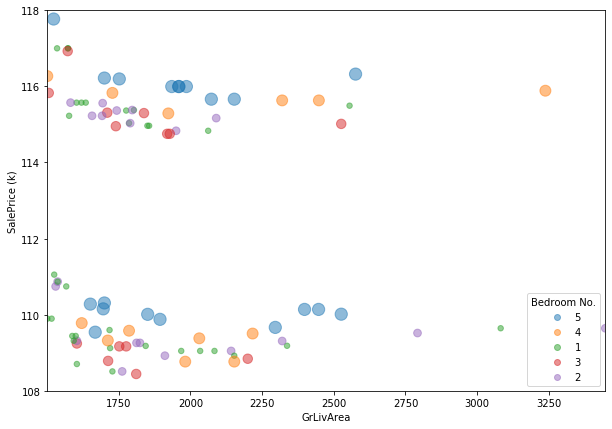

63 1734
OveralQual


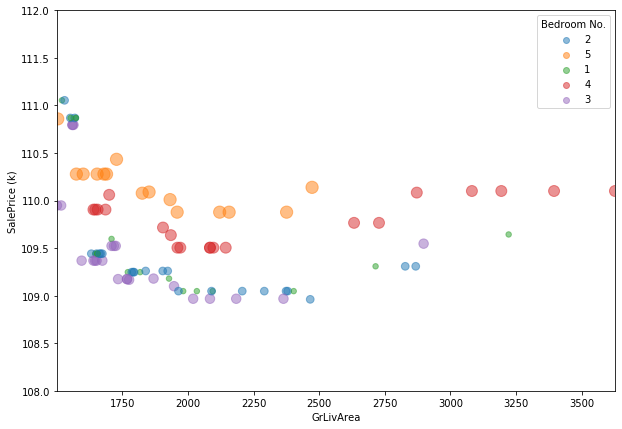

In [453]:
df1 = df_predict.drop('SalePrice',axis=1)

cols = ['MasVnrArea','BsmtFinSF1','MSSubClass','LotFrontage','YearBuilt','OveralQual']
for col in cols:
    
    df_s = df1.sample(n=100,replace=True)
    df_new = simulate_m_n(df_s,col)

    y = simulation_price(model,df_new)
    print(col)
    plot_bedroom(df_new,
                 [math.floor(df_new.GrLivArea.min()),math.ceil(df_new.GrLivArea.max())],
                 [math.floor(df_new.SalePrice.min()),math.ceil(df_new.SalePrice.max())])

(100, 80)

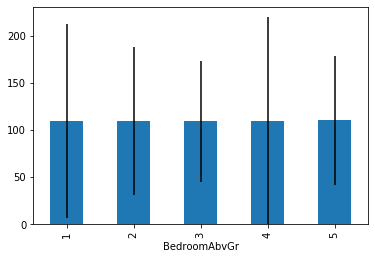

In [448]:
df_new1500 = df_new[df_new.GrLivArea > 1500]
plot_mean_sd_BR(df_new1500)
df_new1500.shape

3 1563
MasVnrArea


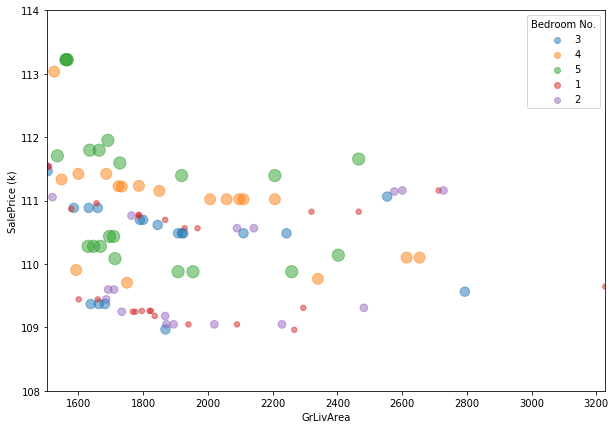

12 1502
BsmtFinSF1


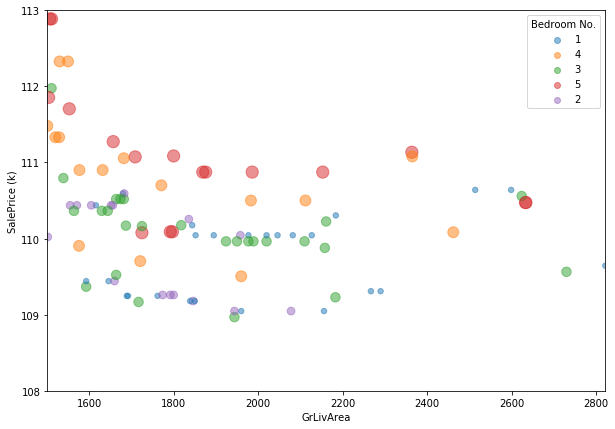

33 1690
MSSubClass


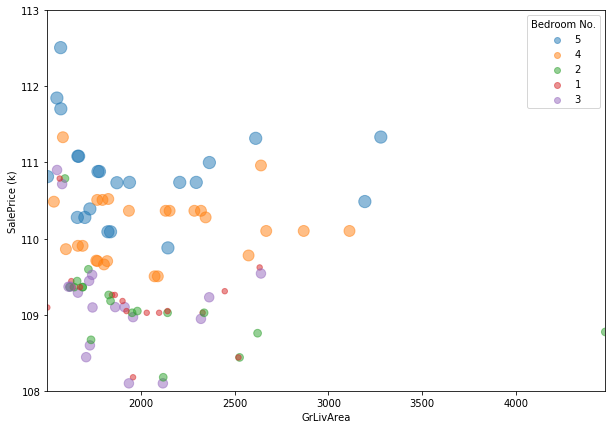

73 1574
LotFrontage


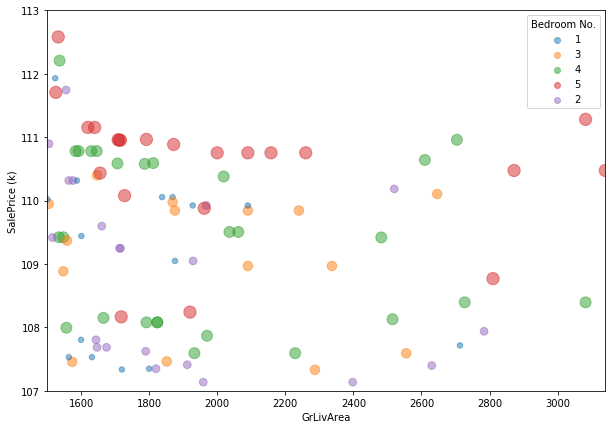

98 2200
YearBuilt


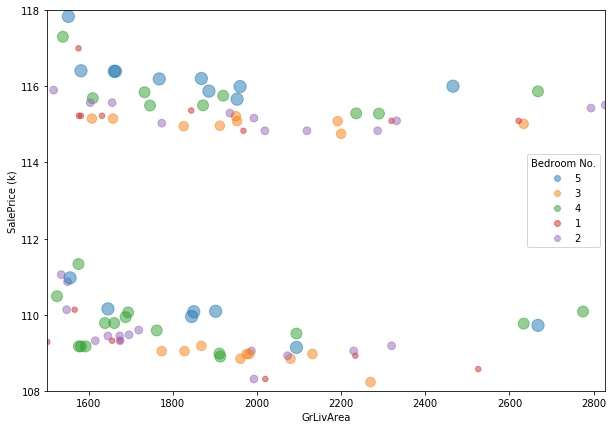

42 1610
OveralQual


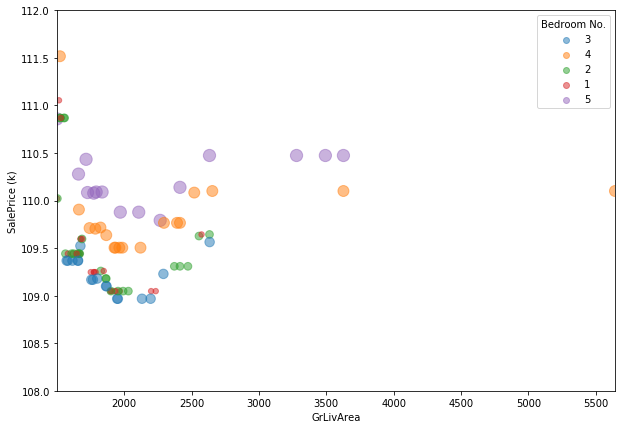

In [450]:
for col in cols:
    
    df_s = df1.sample(n=100,replace=True)
    df_new = simulate_m(df_s,col)

    y = simulation_price(model,df_new)
    print(col)
    plot_bedroom(df_new,
                 [math.floor(df_new.GrLivArea.min()),math.ceil(df_new.GrLivArea.max())],
                 [math.floor(df_new.SalePrice.min()),math.ceil(df_new.SalePrice.max())])

(100, 80)

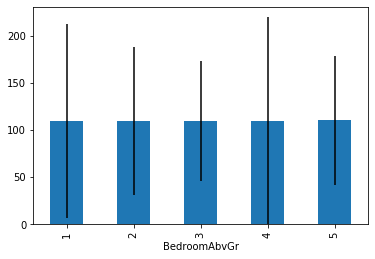

In [454]:
df_new1500 = df_new[df_new.GrLivArea > 1500]
plot_mean_sd_BR(df_new1500)
df_new1500.shape